In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import dill
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tqdm
from keras.layers import Embedding
import numpy as np
from aprec.recommenders.sequential.models.sasrec.sasrec import ExpPositionEncoding, SinePositionEncoding
from scipy.spatial import distance 
import matplotlib as mpl
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")


2022-12-09 07:19:24.717721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 07:19:25.170762: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-09 07:19:25.170802: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-09 07:19:25.170805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [6]:
#experiment="ml_benchmark20m_sasrec_variable_importance_2022_11_08T11_45_30"
#experiment="booking_embedding_similiarities_2022_11_16T09_30_30"

experiment = "yelp_embedding_similiarities_2022_12_08T11_19_57"
results="/mnt/data/experiment_results"
model_file_vanilla = open(f"{results}/{experiment}/checkpoints/Sasrec-rss-vanilla.dill", "rb")
model_file_rss = open(f"{results}/{experiment}/checkpoints/Sasrec-rss-bce-0.8-default-causal.dill", "rb")
#model_file_bidirectional= open(f"{results}/{experiment}//checkpoints/Sasrec-rss-lambdarank-0.8-default-bidirectional.dill", "rb")
    

In [7]:
recommender_vanilla = dill.load(model_file_vanilla)
recommender_rss = dill.load(model_file_rss)
recommender_bidirectional = dill.load(model_file_bidirectional)


2022-12-09 07:22:30.054257: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-09 07:22:30.054282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: desktop
2022-12-09 07:22:30.054287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: desktop
2022-12-09 07:22:30.054455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2022-12-09 07:22:30.054467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2022-12-09 07:22:30.054469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2022-12-09 07:22:30.055472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI De

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2022-12-08 23:36:42    228160240
metadata.json                                  2022-12-08 23:36:42           64
config.json                                    2022-12-08 23:36:42          623
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...embedding_dropout
......vars
...item_embeddings_layer
......vars
.........0
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_6
.........vars
............0
............1
......dense_7
.........vars
............0
............1
......dense_8
.........vars
............0
........

NameError: name 'model_file_bidirectional' is not defined

In [8]:
try:
    user_ids = recommender_vanilla.recommender.users.straight
except AttributeError:
    user_ids = recommender_vanilla.users.straight

In [9]:
try:
    sasrec_recommender_vanilla = recommender_vanilla.recommender
    sasrec_recommender_rss = recommender_rss.recommender
except AttributeError:
    sasrec_recommender_vanilla = recommender_vanilla
    sasrec_recommender_rss = recommender_rss
    

In [10]:
all_items = np.arange(50)
embs_vanilla = sasrec_recommender_vanilla.model.postion_embedding_layer(all_items)
embs_rss = sasrec_recommender_rss.model.postion_embedding_layer(all_items)

In [11]:
def plot_two_maps(map1, map2, title1, title2, vmax=None, save_filename=None):
    scale = 5
    f,(ax1,ax2, axcb) = plt.subplots(1,3, gridspec_kw={'width_ratios':[1,1,0.1]}, figsize=(scale*1.16, scale/2))
    #f.tight_layout()
    cmap = mpl.cm.get_cmap('autumn_r')
    ax1.get_shared_y_axes().join(ax2)
    g1 = sns.heatmap(map1, cmap="YlGnBu", cbar=False, ax=ax1, vmax=vmax)
    g1.set_ylabel('')
    g1.set_xlabel('')
    g1.set_title(title1)
    
    g2 = sns.heatmap(map2, cmap="YlGnBu", cbar_ax=axcb, ax=ax2, vmax=vmax)
    g2.set_ylabel('')
    g2.set_xlabel('')
    g2.axes.get_yaxis().set_ticks([])
    g2.set_title(title2)
    

    
    if save_filename is not None:
        f.savefig(save_filename)

    

/tmp/ipykernel_667638/2843714226.py:6: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax2)


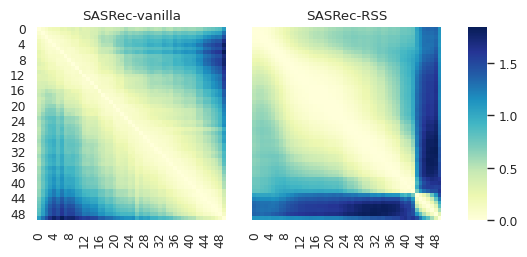

In [12]:
def pos_sim(emb1, emb2):
    dist = distance.cosine(emb1, emb2)
    return dist

def sim_matr(embs):
    result = []
    for i in range(len(embs)):
        result.append([])
        emb1 = embs[i]
        for j in range(len(embs)):
            emb2 = embs[j]
            result[-1].append(pos_sim(emb1, emb2))
    return np.array(result)

def k_sims(embs, pos, k):
    cnt = 0
    s = 0
    for i in range(pos - k, pos+k):
        for j in range(i+1, pos+k+1):
            s += pos_sim(embs[i], embs[j])
            cnt +=1
    return s/cnt

plot_two_maps(sim_matr(embs_vanilla), sim_matr(embs_rss), "SASRec-vanilla", "SASRec-RSS", vmax=None, save_filename="position_similarity_maps.svg")

In [13]:
def get_attention_maps(user_id, model, layer=0):
    inputs = model.get_model_inputs(user_id)[0]
    with tf.device('/cpu:0'):
        seq, attn = model.model.get_seq_embedding(inputs)
    return attn[layer][0].numpy()

def plot_attention_maps(model1, model_name1, model2, model_name2, layer=0):
    user_lens = {}
    for key in user_ids.keys():
        uid = user_ids[key]
        n_items = len(model1.user_actions[uid])
        if n_items > 20:
            user_lens[key] = n_items
    maps1 = []
    maps2 = []
    while len(maps1) < 1000:
        uid = np.random.choice(list(user_lens.keys()))
        maps1.append(get_attention_maps(uid, model1, layer))
        maps2.append(get_attention_maps(uid, model2, layer))
    mean_attentions1 = np.mean(maps1, axis=0)
    mean_attentions2 = np.mean(maps2, axis=0)
    plot_two_maps(mean_attentions1, mean_attentions2, model_name1, model_name2, 0.06)
    #sns.heatmap(mean_attentions1, vmax=0.06, cmap="Greens")

In [15]:
#plot_attention_maps(sasrec_recommender_vanilla, "SASRec-Vanilla", sasrec_recommender_rss, "SASRec-RSS", layer=0)

/tmp/ipykernel_667638/2843714226.py:6: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax2)


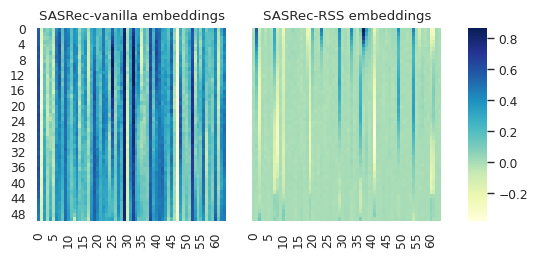

In [16]:

plot_two_maps(embs_vanilla, embs_rss, "SASRec-vanilla embeddings", "SASRec-RSS embeddings", vmax=None)


In [17]:
from umap import UMAP
def plot_umap_embeddings(embeddings1, title1, embeddings2, title2,seed=107):
    embeddings = tf.concat([embeddings1, embeddings2], 0)
    mapper = UMAP(n_components=2, metric="cosine", random_state=seed).fit(embeddings)
    matr1 = mapper.embedding_[:len(embeddings1)]
    matr2 = mapper.embedding_[len(embeddings1):]
    N = len(embeddings1)
    cmap = mpl.cm.get_cmap('autumn_r')
    norm = mpl.colors.Normalize(vmin=0, vmax=len(embeddings1) - 1)
    fig, ax = plt.subplots(1,3,figsize=(20, 7), gridspec_kw={'width_ratios': [1, 1, 0.05]})
    for i in range(len(embeddings1)):
        emb1 = matr1[i]
        emb2 = matr2[i]
        color = cmap(norm(i))
        ax[0].scatter(emb1[0], emb1[1], color=color)
        ax[1].scatter(emb2[0], emb2[1], color=color)
    ax[0].set_title(title1)
    ax[1].set_title(title2)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax[2], orientation='vertical', label='Position')
    fig.savefig(f'umap_embeddings.svg')
    
plot_umap_embeddings(embs_vanilla, "SASRec-vanilla", embs_rss, "SASRec-RSS", 107)

ModuleNotFoundError: No module named 'umap'

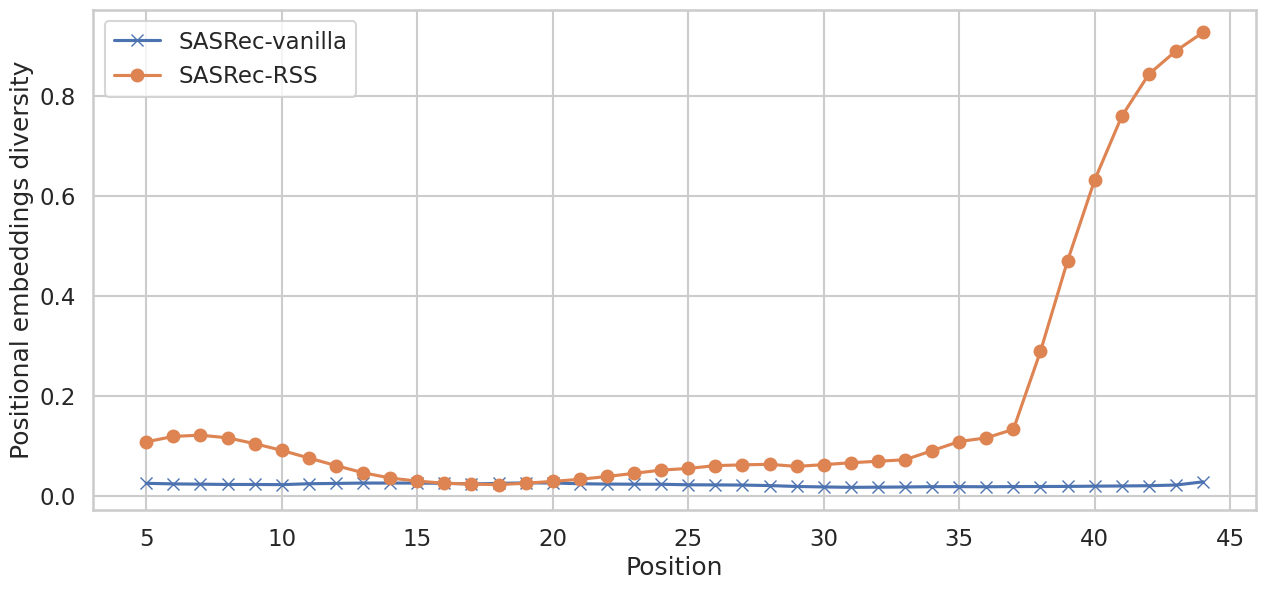

In [18]:
k = 5
x = []
y_vanilla = []
y_rss = []
sns.set_context("talk")
for i in range(k, len(embs_vanilla)-k):
    x.append(i)
    y_vanilla.append(k_sims(embs_vanilla, i, k))
    y_rss.append(k_sims(embs_rss, i, k))
plt.figure(figsize=(15,6.5))
plt.plot(x, y_vanilla, label="SASRec-vanilla", marker="x")
plt.plot(x, y_rss, label="SASRec-RSS", marker="o")
plt.xlabel("Position")
plt.ylabel("Positional embeddings diversity")
plt.legend()
plt.savefig("embeddings_diversity.svg")

/tmp/ipykernel_667638/2843714226.py:6: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax2)


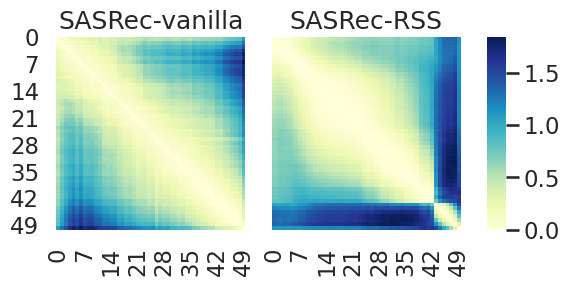

In [19]:
plot_two_maps(sim_matr(embs_vanilla), sim_matr(embs_rss), "SASRec-vanilla", "SASRec-RSS", vmax=None, save_filename="position_similarity_maps.svg")

In [210]:
class SinePositionEncoding(keras.layers.Layer):
    def __init__(
        self,
        seq_length, 
        hidden_size,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength
        self.seq_length = seq_length
        self.hidden_size = hidden_size
    
    def call(self, positions):
        seq_length = self.seq_length
        hidden_size = self.hidden_size
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )
        return tf.gather(positional_encodings, positions)


In [92]:
class ExpPositionalEncoding(keras.layers.Layer):
    def __init__(self, seq_len, emb_size, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.emb_size = emb_size
        pows_initalizer = tf.random_uniform_initializer(-3, 3)
        self.pow = tf.Variable(initial_value=pows_initalizer(shape=(emb_size, )), trainable=True)
        
    
    def __call__(self, positions):
        w = tf.exp(self.pow)
        for i in range(len(positions.shape)):
            w = tf.expand_dims(w, 0)
        tiles = list(positions.shape) + [1]
        w = tf.tile(w, tiles)
        positions_norm = tf.cast((positions+1), 'float32')/(self.seq_len+1)
        pos = tf.tile(tf.expand_dims(positions_norm, -1), [1] * len(positions.shape) + [self.emb_size])
        return tf.pow(pos, w)